In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import numpy as np
from arch.unitroot import PhillipsPerron
from dotenv import load_dotenv
from statsmodels.tsa.vector_ar.vecm import VAR
from statsmodels.tsa.stattools import adfuller, pacf, coint
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from math import log
from scipy.stats import pearsonr
from datetime import datetime, timedelta

def plot_df(price_series1, price_series2=None, price_series3=None, price_series4 = None, merge_and_plot=False, title="", xlabel="", ylabel="", color="blue"):
    plt.style.use('default')

    if merge_and_plot and price_series2 is not None:
        plt.plot(price_series1, color="blue", linewidth=0.75, label=f"{ticker1} (Forecast)")
        plt.plot(price_series2, color="green", linewidth=0.75, label=f"{ticker2} (Actual)")
        plt.legend()
    else:
        plt.plot(price_series1, color, linewidth=0.75)
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    year_locator = mdates.YearLocator(base=1)
    plt.gca().xaxis.set_major_locator(year_locator)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def difference(price_series):
    new_series = price_series - price_series.shift(1)
    new_series = new_series.dropna()
    new_index = price_series.index[1:]
    new_series.index = new_index
    
    return new_series

load_dotenv()
path_to_data = os.getenv("PATH_TO_DATA") 

def get_data(ticker1, ticker2, path_to_data):
    pair_paths = dict()
    for root, dirs, files in os.walk(path_to_data):
        for name in files:
            if name == f"{ticker1}.csv":
                ticker1_path = str(os.path.join(root, name))
                pair_paths[ticker1] = ticker1_path
            elif name == f"{ticker2}.csv":
                ticker2_path = str(os.path.join(root, name))
                pair_paths[ticker2] = ticker2_path
    return pair_paths

ticker1 = "AZN"
ticker2 = "PFE"

start_time = "2004-06-16"
end_time = "2010-06-16"
forecast_days = 15

# Training set would be between "2004-06-16" and "2010-06-16"
# Testing set would be between "2010-06-16" and the number of days we want to forecast.

pair_paths = get_data(ticker1, ticker2, path_to_data)


with open(rf"{pair_paths[ticker1]}", "r") as s1:
    with open(rf"{pair_paths[ticker2]}", "r") as s2:
        unclean_price_series1 = pd.read_csv(s1)
        print(ticker1 + "\n", unclean_price_series1)

        unclean_price_series2 = pd.read_csv(s2)
        print(ticker2 + "\n", unclean_price_series2)



AZN
       Unnamed: 0    datetime   open   high    low  close   volume
0              0  2023-04-19  74.55  74.90  74.41  74.84  4487800
1              1  2023-04-18  75.36  75.83  74.47  75.02  7565700
2              2  2023-04-17  73.76  73.82  73.01  73.63  4408700
3              3  2023-04-14  74.33  74.47  73.57  73.86  3981100
4              4  2023-04-13  74.05  74.83  74.02  74.77  3794200
...          ...         ...    ...    ...    ...    ...      ...
4740        4740  2004-06-21  23.75  23.80  23.63  23.63   841400
4741        4741  2004-06-18  23.79  23.94  23.77  23.77  1615200
4742        4742  2004-06-17  23.64  23.70  23.52  23.68  1135600
4743        4743  2004-06-16  23.75  23.82  23.63  23.77  1060400
4744        4744  2004-06-15  23.43  23.57  23.39  23.48  1637400

[4745 rows x 7 columns]
PFE
       Unnamed: 0    datetime   open   high    low  close    volume
0              0  2023-04-19  40.43  40.56  40.20  40.24  17207800
1              1  2023-04-18  41.28  41

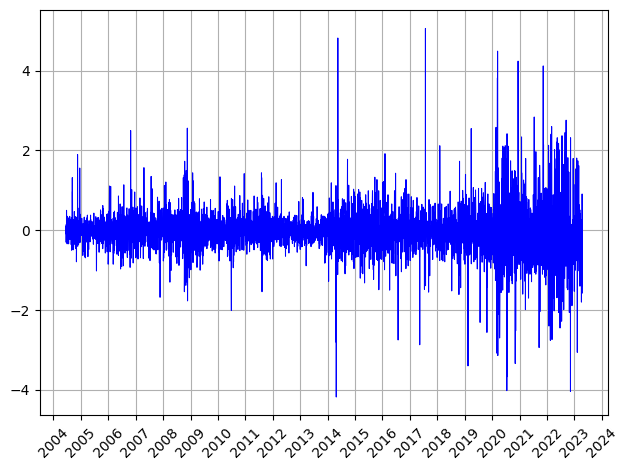

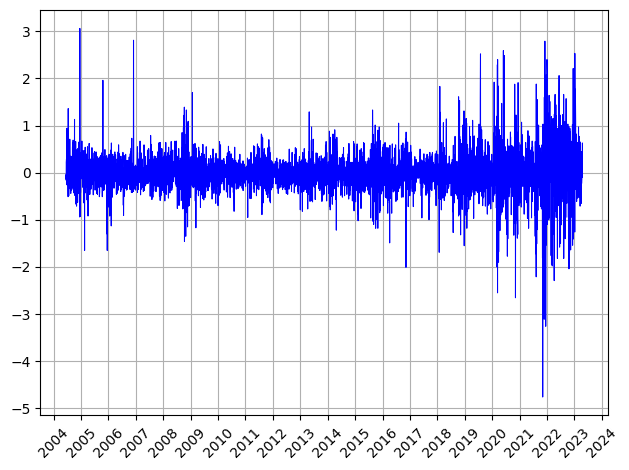

In [4]:
def clean_df(unclean_price_series):
    price_df = unclean_price_series.set_index('datetime')
    price_df.index = pd.to_datetime(price_df.index)
    new_price_df = price_df['close'].copy()
    new_price_df = difference(new_price_df)
    new_price_df.index.asfreq = 'D'
    return new_price_df

price_series1_whole = clean_df(unclean_price_series1)
price_series2_whole = clean_df(unclean_price_series2)

plot_df(price_series1_whole)
plot_df(price_series2_whole)

In [5]:
def create_training_set(price_series, start_time, end_time):
    new_price_series = price_series
    new_price_series = new_price_series.truncate(start_time, end_time)
    return new_price_series

price_series1 = create_training_set(price_series1_whole, start_time, end_time)
price_series2 = create_training_set(price_series2_whole, start_time, end_time)
print(ticker1 + "\n", price_series1)
print(ticker2 + "\n", price_series2)



AZN
 datetime
2010-06-16    0.00
2010-06-15    0.09
2010-06-14   -0.46
2010-06-11   -0.01
2010-06-10   -0.42
              ... 
2004-06-22   -0.31
2004-06-21    0.08
2004-06-18    0.14
2004-06-17   -0.09
2004-06-16    0.09
Name: close, Length: 1512, dtype: float64
PFE
 datetime
2010-06-16    0.01
2010-06-15    0.04
2010-06-14   -0.18
2010-06-11    0.13
2010-06-10   -0.53
              ... 
2004-06-22   -0.06
2004-06-21    0.29
2004-06-18    0.22
2004-06-17   -0.16
2004-06-16   -0.04
Name: close, Length: 1512, dtype: float64


In [6]:
start_time = "2010-06-17"
start_date = datetime.strptime("2010-06-17", "%Y-%m-%d")
end_date = start_date + timedelta(days=forecast_days)
end_time = end_date.strftime("%Y-%m-%d")


def create_test_set(price_series, start_time, end_time):
    test_set = price_series
    test_set = test_set.truncate(start_time, end_time)
    return test_set

test_set1 = create_test_set(price_series1_whole, start_time, end_time)
test_set2 = create_test_set(price_series2_whole, start_time, end_time)

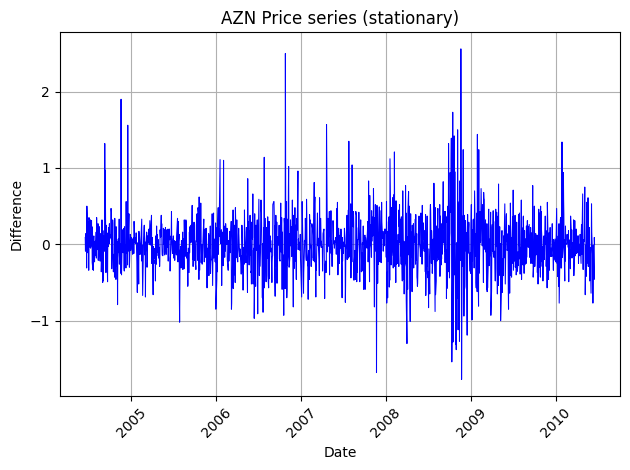

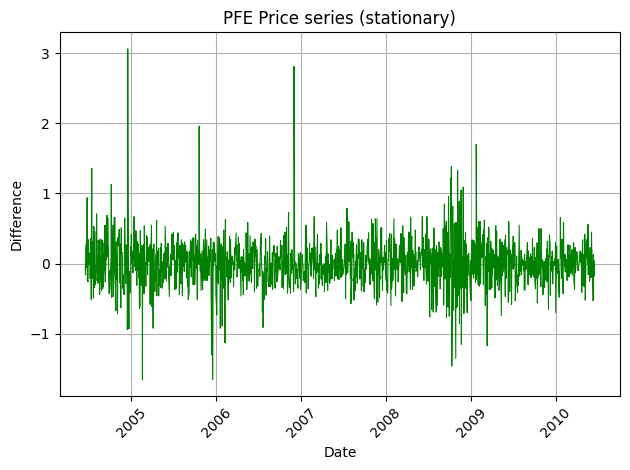

In [7]:

plot_df(price_series1, title=f"{ticker1} Price series (stationary)", xlabel="Date", ylabel="Difference", color="blue")
plot_df(price_series2, title=f"{ticker2} Price series (stationary)", xlabel="Date", ylabel="Difference", color="green")

In [8]:
pp1 = PhillipsPerron(price_series1, trend='n')
print(ticker1 + "...\n", str(pp1.summary()), "\n")

pp2 = PhillipsPerron(price_series2, trend='n')
print(ticker2 + "...\n", str(pp2.summary()))

AZN...
      Phillips-Perron Test (Z-tau)    
Test Statistic                -39.594
P-value                         0.000
Lags                               24
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

PFE...
      Phillips-Perron Test (Z-tau)    
Test Statistic                -39.051
P-value                         0.000
Lags                               24
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [9]:
result = adfuller(price_series1)
result2 = adfuller(price_series2)

print("p val", result[1])
print("p val", result2[1])

p val 1.6410552858534234e-21
p val 2.0682275928364335e-10


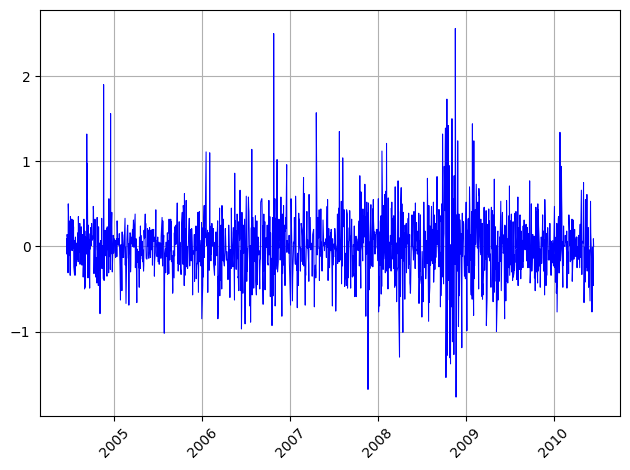

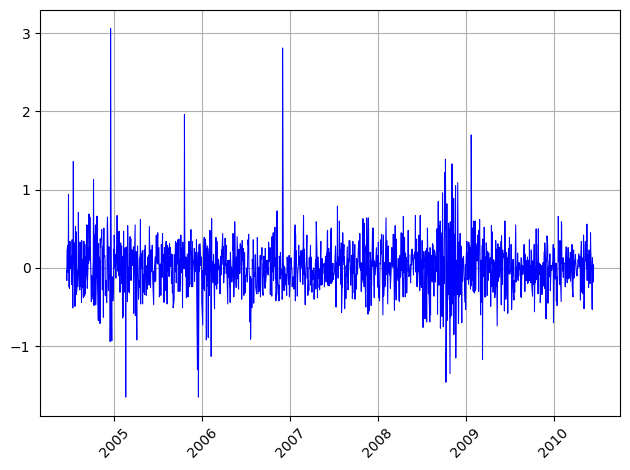

Cointegration ratio for rolling window 35: 0.82


In [10]:
window_size = 35
cointegration_results = []
plot_df(price_series1)
plot_df(price_series2)
for i in range(len(price_series1) - window_size + 1):
    window_price_series1 = price_series1[i:i+window_size]
    window_price_series2 = price_series2[i:i+window_size]
    score, p_value, _ = coint(window_price_series1, window_price_series2)
    cointegration_results.append(p_value < 0.05)

num_cointegrated = sum(cointegration_results)
coint_ratio = num_cointegrated/len(cointegration_results)

print(f"Cointegration ratio for rolling window {window_size}: {round(coint_ratio, 2)}")

Lag: 10
PearsonRResult(statistic=0.07956733669800796, pvalue=0.0020286212852025556)
------
Lag: 14
PearsonRResult(statistic=-0.07261201894660584, pvalue=0.004927399555517377)
------
Lag: 20
PearsonRResult(statistic=0.10314482885169377, pvalue=6.567728192521228e-05)
------


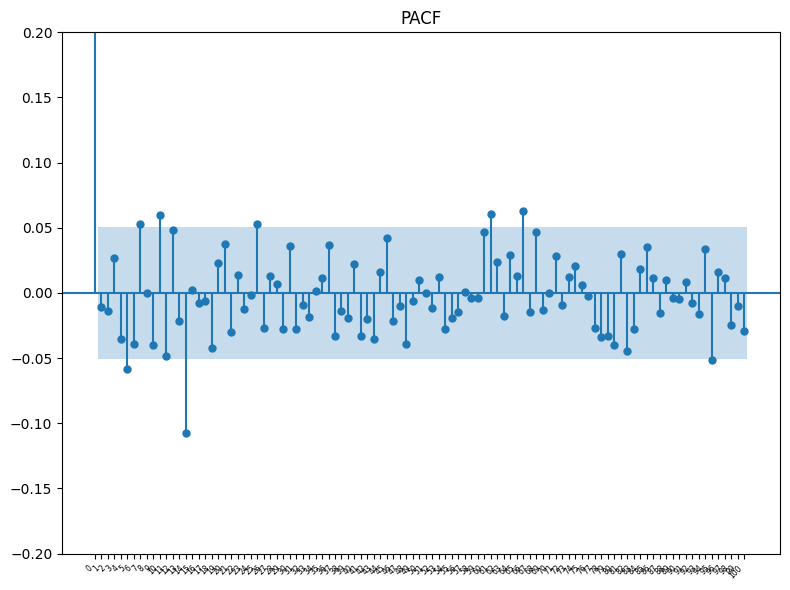

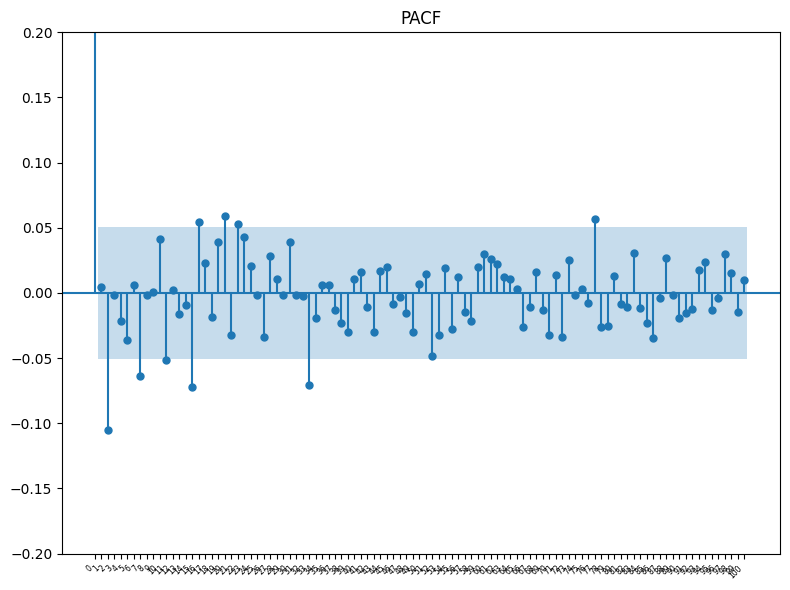

In [11]:
def plot_and_extract_pacf(price_df, title, lags):
    fig, ax = plt.subplots(figsize=(8, 6))
    y_limit = 0.2
    plot_pacf(price_df, lags=lags, ax=ax)
    ax.set_title(title)
    ax.set_ylim(-y_limit, y_limit)
    tick_positions = np.arange(0, lags + 1)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_positions, rotation=45, ha='right', fontsize=5.5)
    plt.tight_layout()
    plt.show()


def pearson_corr_lags(merged_series, lags):
    for lag in range(1, lags+1):
        price_series1 = merged_series['price1'].iloc[lag:]
        lagged_price_series2 = merged_series['price2'].iloc[:-lag]
        vals = pearsonr(price_series1, lagged_price_series2)
        
        if vals[1] <= 0.01:
            print(f"Lag: {lag}")
            print(vals)
            print("------")
        

lags = 100

merged_series = pd.DataFrame()
merged_series.index = price_series1.index
merged_series['price1'] = price_series1
merged_series['price2'] = price_series2

pearson_corr_lags(merged_series, lags)


result1 = plot_and_extract_pacf(price_series1, title="PACF", lags=lags)
result2 = plot_and_extract_pacf(price_series2, title="PACF", lags=lags)










For price_series1, lag orders 1,9,14,15

For price_series2, lag orders 1,2,15

We'll first look at AR models.

In [12]:
ar_orders1 = [5, 10, 14]
ar_orders2 = [2, 7, 10, 14, 15, 16, 20, 22]

merged_series = pd.DataFrame()
merged_series.index = price_series1.index
merged_series['price1'] = price_series1
merged_series['price2'] = price_series2

model = VAR(merged_series)
model_fit = model.fit(maxlags=20)
selected_lag_order = model_fit.k_ar
print(selected_lag_order)


20


f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [13]:
p_values = model_fit.pvalues
for lag, val in p_values['price1'].items():
    if val <= 0.05:
        print(f"{lag}: p-value = {round(val, 3)}")
print("-----------------")
for lag, val in p_values['price2'].items():
    if val <= 0.05:
        print(f"{lag}: p-value = {round(val, 3)}")

L1.price2: p-value = 0.048
L2.price2: p-value = 0.044
L7.price1: p-value = 0.014
L14.price1: p-value = 0.004
L20.price2: p-value = 0.003
-----------------
L2.price2: p-value = 0.0
L7.price1: p-value = 0.011
L7.price2: p-value = 0.001
L12.price1: p-value = 0.033
L15.price2: p-value = 0.024
L16.price2: p-value = 0.011
L18.price1: p-value = 0.01
L20.price2: p-value = 0.014


2, 14,15,16,18,20

f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


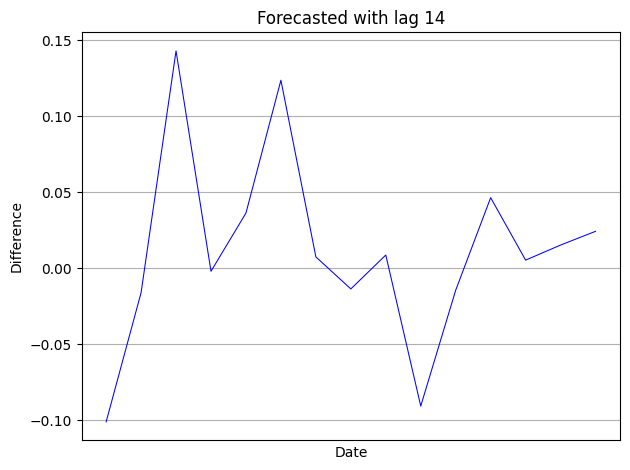

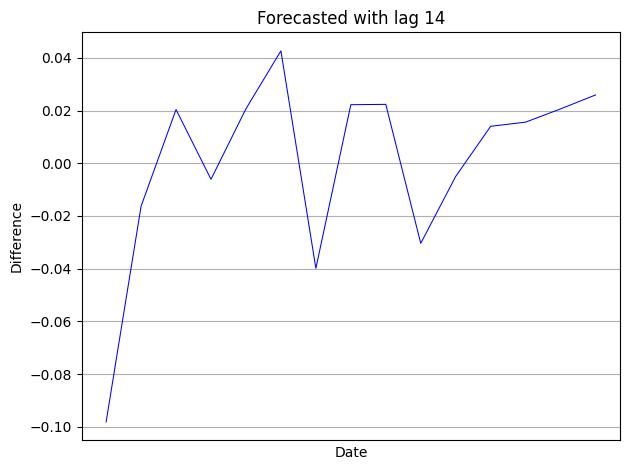

f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


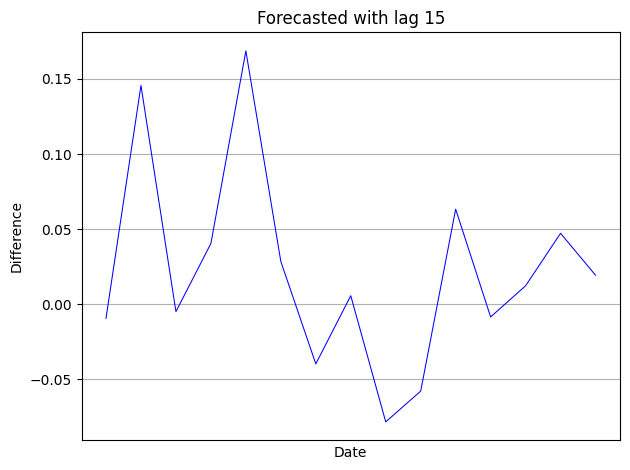

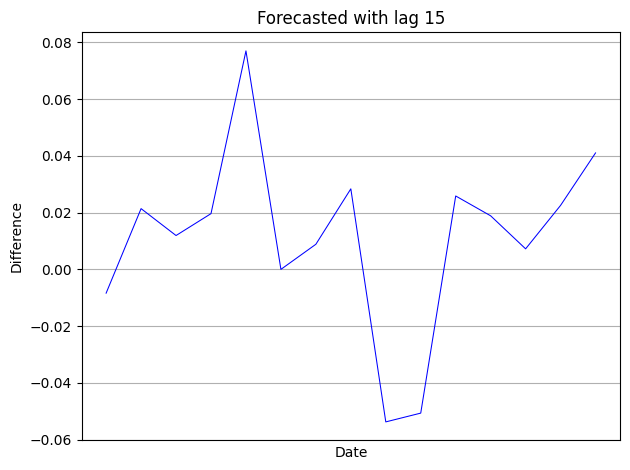

f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


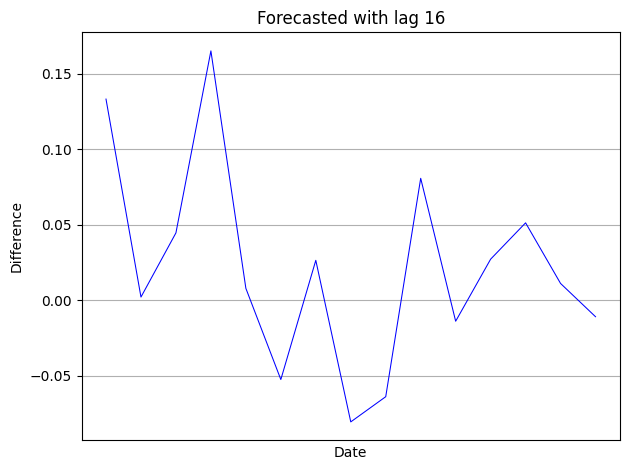

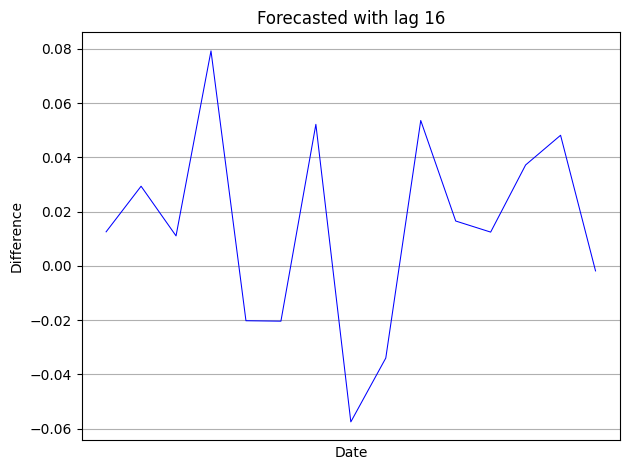

f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


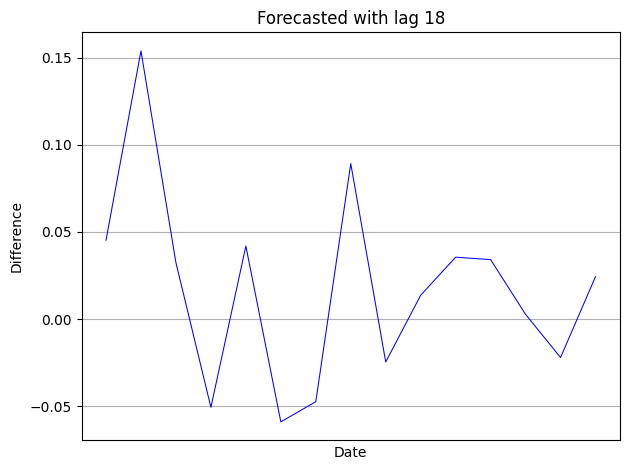

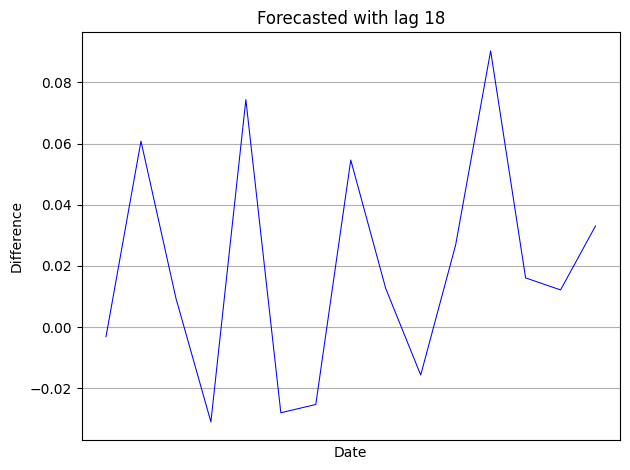

f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


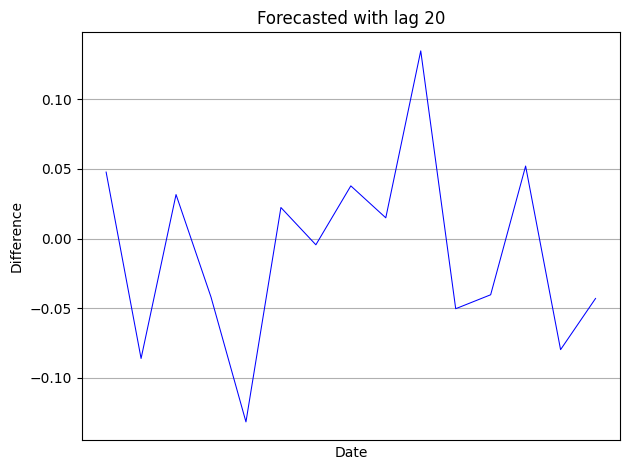

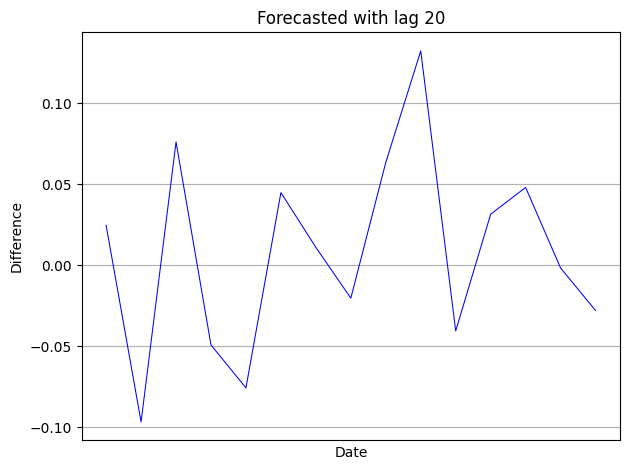

f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


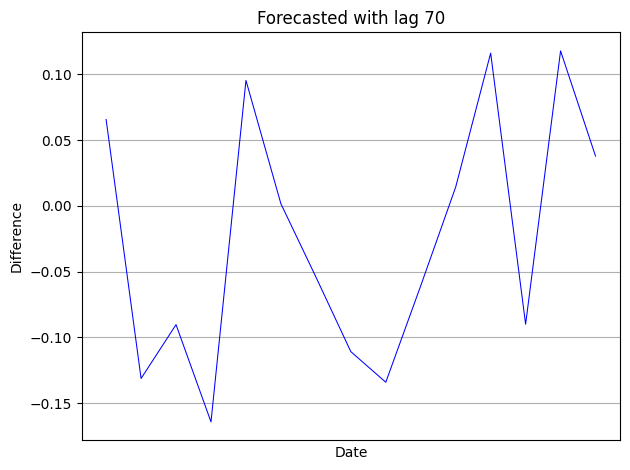

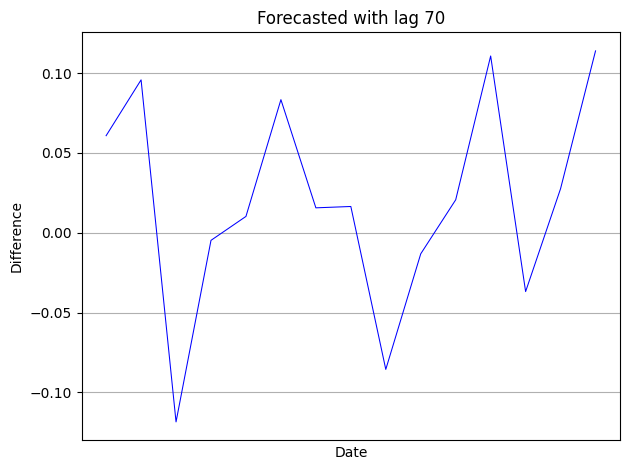

In [14]:
def test_different_lag_orders(lag_order, merged_series, forecast_days):
    model = VAR(merged_series)
    model_fit = model.fit(lag_order)
    last_lagged_observations = merged_series[:lag_order]
    forecast = model_fit.forecast(last_lagged_observations.values, steps=forecast_days)
    forecast_df = pd.DataFrame(forecast, columns=merged_series.columns)
    forecast_dates = pd.date_range(start=merged_series.index[0] + pd.DateOffset(days=1), periods=forecast_days, freq='D')
    forecast_df.index = forecast_dates
    return forecast_df

merged_series = pd.DataFrame()
merged_series.index = price_series1.index
merged_series['price1'] = price_series1
merged_series['price2'] = price_series2
lag_orders = [14, 15, 16, 18, 20, 70]
for lag in lag_orders:
    forecasted = test_different_lag_orders(lag, merged_series, forecast_days)
    plot_df(forecasted['price1'], title=f"Forecasted with lag {lag}", xlabel="Date", ylabel="Difference", color="blue")
    plot_df(forecasted['price2'], title=f"Forecasted with lag {lag}", xlabel="Date", ylabel="Difference", color="blue")


In [15]:
start_time = "2010-06-17"
end_time = "2016-06-17"

unseen_set1 = create_test_set(unclean_price_series1, start_time, end_time)
unseen_set2 = create_test_set(unclean_price_series2, start_time, end_time)